In [48]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV, Ridge
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [49]:
filename_one = './homework_data/yellow_tripdata_2023-01.parquet'
filename_two = './homework_data/yellow_tripdata_2023-02.parquet'
df_one = pd.read_parquet(filename_one)
df_two = pd.read_parquet(filename_two)

Download the data for January and February 2023.
1. Read the data for January. How many columns are there?

In [50]:
print("Length of columns: ", len(df_one.columns))

Length of columns:  19


In [51]:
df_one.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


2. Now let's compute the duration variable. It should contain the duration of a ride in minutes.<br>
What's the standard deviation of the trips duration in January?

In [52]:
df_one['duration'] = df_one.tpep_dropoff_datetime - df_one.tpep_pickup_datetime
df_one.duration = df_one.duration.apply(lambda td: td.total_seconds() / 60)
print("Standard deviation of trips duration in January", np.std(df_one.duration))

Standard deviation of trips duration in January 42.59434429744777


In [53]:
df_one.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


3. Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
What fraction of the records left after you dropped the outliers?

Original data count:  3066766
Filtered data count:  3009173
Fraction of records remaining after removing outliers: 98.12%


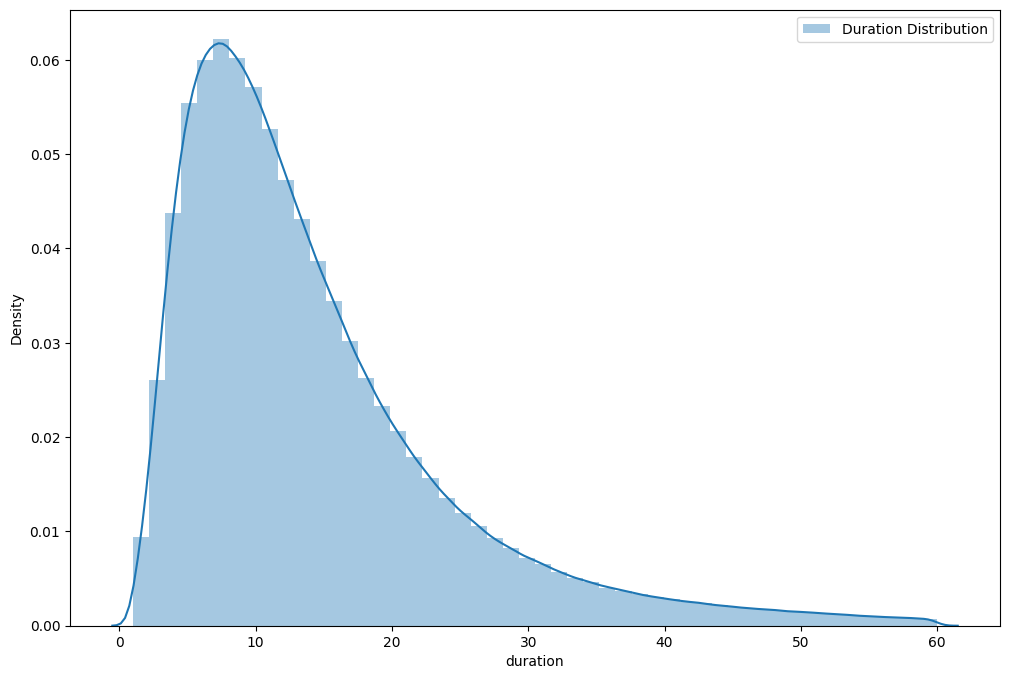

In [54]:
# Store the original number of records
original_count = len(df_one.duration)
print("Original data count: ", original_count)

# Filter the dataset to keep durations between 1 and 60 minutes
df_filtered = df_one[(df_one.duration >= 1) & (df_one.duration <= 60)]

# Store the new count after filtering
filtered_count = len(df_filtered)
print("Filtered data count: ", filtered_count)

# Calculate the fraction remaining
fraction_remaining = filtered_count / original_count

# Print the result
print(f"Fraction of records remaining after removing outliers: {fraction_remaining:.2%}")

# Plot the distribution of the filtered durations
plt.figure(figsize=(12, 8))
sns.distplot(df_filtered.duration, label='Duration Distribution')
plt.legend()

4. Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.
    - Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
    - Fit a dictionary vectorizer
    - Get a feature matrix from it
    - What's the dimensionality of this matrix (number of columns)?

In [55]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dict_vectorizer = DictVectorizer()
df_dicts = df_one[categorical + numerical].to_dict(orient="records")
X_train = dict_vectorizer.fit_transform(df_dicts)
print("The dimensionality of this matrix (number of columns): ", X_train.ndim)

The dimensionality of this matrix (number of columns):  2


5. Now let's use the feature matrix from the previous step to train a model.
    - Train a plain linear regression model with default parameters, where duration is the response variable
    - Calculate the RMSE of the model on the training data
    - What's the RMSE on train?

In [58]:
target =  "duration"
y_train = df_one[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
root_mean_squared_error(y_train, y_pred)

42.56058681173718

In [81]:
def read_dataframe(filename):
    
    # 1. Read the dataset
    df = pd.read_parquet(filename)
    # To modify the original DataFrame instead of creating a new one, use inplace=True
    df.drop(['store_and_fwd_flag', 'ehail_fee'], axis=1, inplace=True)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    potential_leakage = ['total_amount']  # Features that might include duration in their calculation
    features_to_drop = potential_leakage.copy()

    # Create a clean dataset for feature selection
    X_full = df.drop(['duration'] + features_to_drop, axis=1)
    y = df['duration']
    
    # Step 2: Initial Feature Screening
    # Calculate correlations with target
    correlations = pd.DataFrame(X_full.corrwith(y).abs().sort_values(ascending=False))
    correlations.columns = ['Correlation with Duration']
    print("Feature correlations with duration:")
    print(correlations.head(10))
    
    # Extract time features if timestamps are available
    if 'lpep_pickup_datetime' in X_full.columns:
        # Convert to datetime if not already
        X_full['lpep_pickup_datetime'] = pd.to_datetime(X_full['lpep_pickup_datetime'])
        
        # Extract hour of day and day of week
        X_full['pickup_hour'] = X_full['lpep_pickup_datetime'].dt.hour
        X_full['pickup_day_of_week'] = X_full['lpep_pickup_datetime'].dt.dayofweek
        
        # Create rush hour feature
        X_full['is_rush_hour'] = ((X_full['pickup_hour'] >= 7) & (X_full['pickup_hour'] <= 10) | 
                                (X_full['pickup_hour'] >= 16) & (X_full['pickup_hour'] <= 19)).astype(int)
        
        # Drop original timestamp columns as they can't be used in linear models
        X_full = X_full.drop(['lpep_pickup_datetime', 'lpep_dropoff_datetime'], axis=1, errors='ignore')

    # Log transform skewed features (like trip_distance)
    if 'trip_distance' in X_full.columns:
        X_full['log_trip_distance'] = np.log1p(X_full['trip_distance'])

    # Step 4: Handle Categorical Variables
    # Identify categorical columns
    categorical_cols = X_full.select_dtypes(include=['object', 'category']).columns.tolist()

    # Add categorical columns with low cardinality
    for col in X_full.columns:
        if X_full[col].nunique() < 10 and col not in categorical_cols:
            categorical_cols.append(col)

    # One-hot encode categorical variables
    X_encoded = pd.get_dummies(X_full, columns=categorical_cols, drop_first=True)
    print(f"\nShape after encoding: {X_encoded.shape}")
    
    return X_encoded, y

In [82]:
X_train, y_train = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
X_test, y_test = pd.read_parquet('./data/green_tripdata_2021-02.parquet')

In [83]:
# Step 5: Lasso-Based Feature Selection

# Scale the features (important for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use LassoCV to find the optimal alpha parameter
lassoCV = LassoCV(cv=5, random_state=42, max_iter=10000)
lassoCV.fit(X_train_scaled, y_train)
optimal_alpha = lassoCV.alpha_
print(f"\nOptimal alpha parameter: {optimal_alpha:.6f}")


Optimal alpha parameter: 0.009951


In [84]:
# Apply Lasso with the optimal alpha
lasso = Lasso(alpha=optimal_alpha, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

# Step 6: Analyze Selected Features
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_
})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
selected_features = feature_importance[feature_importance['Coefficient'] != 0].sort_values('Abs_Coefficient', ascending=False)

print("\nLasso Selected Features:")
print(selected_features)


Lasso Selected Features:
                       Feature  Coefficient  Abs_Coefficient
1                  fare_amount     5.863455         5.863455
6            log_trip_distance     5.163730         5.163730
523                mta_tax_0.5     1.501239         1.501239
0                trip_distance    -1.294114         1.294114
525  improvement_surcharge_0.3    -0.535466         0.535466
..                         ...          ...              ...
187            PULocationID_34     0.000622         0.000622
148           PULocationID_236    -0.000563         0.000563
452            DOLocationID_44    -0.000555         0.000555
263           DOLocationID_109    -0.000437         0.000437
282           DOLocationID_127    -0.000170         0.000170

[477 rows x 3 columns]


In [85]:
# Step 8: Evaluate Selected Features
# Get the names of selected features
selected_feature_names = selected_features['Feature'].tolist()
print(f"\nNumber of features selected by Lasso: {len(selected_feature_names)}")


Number of features selected by Lasso: 477


In [91]:
import os

# Create a dataset with only selected features
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

# Demonstrate model performance with selected features
from sklearn.linear_model import LinearRegression, Ridge

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge()
}

print("\nModel Performance with Selected Features:")
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    # Save the model to the models folder
    model_filename = os.path.join('models', f"{name.lower().replace(' ', '_')}_model.bin")
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Saved {name} model to {model_filename}")
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: RMSE = {np.sqrt(mse):.4f}, R² = {r2:.4f}")


Model Performance with Selected Features:
Saved Linear Regression model to models\linear_regression_model.bin
Linear Regression: RMSE = 5.7950, R² = 0.7469
Saved Ridge Regression model to models\ridge_regression_model.bin
Ridge Regression: RMSE = 5.7917, R² = 0.7472


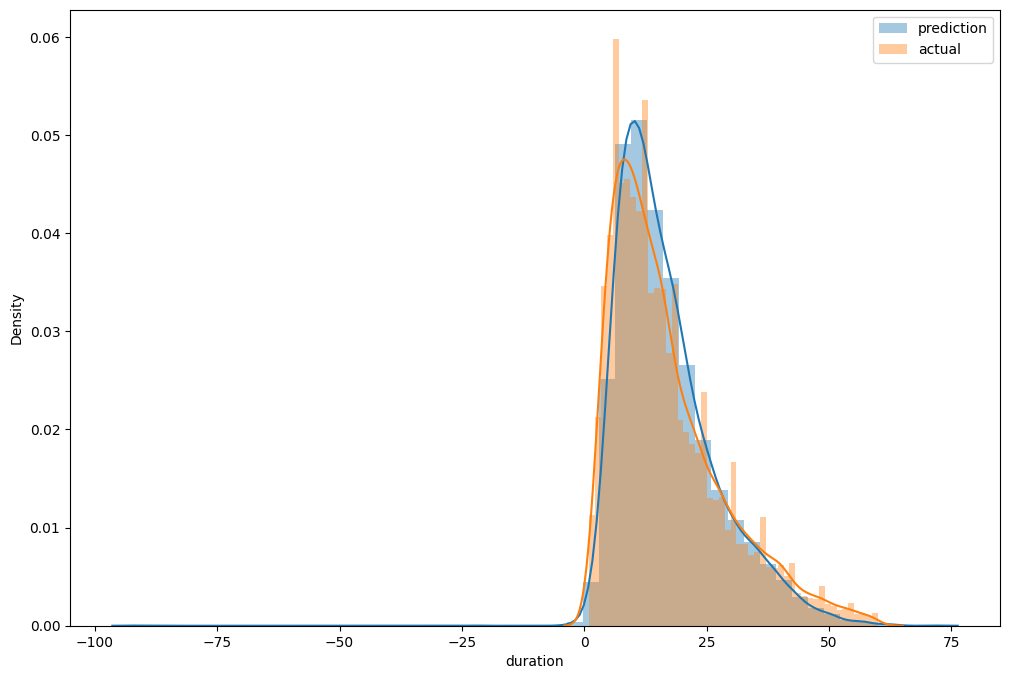

In [87]:
plt.figure(figsize=(12, 8))
sns.distplot(y_pred, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()